In [1]:
import yaml
import os

from agent import q_agent
from utils.dataprep import load_emb_gz, make_categories, load_emb

Using TensorFlow backend.


In [2]:
dataset = "data/imagenet-27x80-vgg19.test-ctg.emb.gz"
path2ind, path_list, embeddings = load_emb_gz(dataset)
categories = make_categories(path_list)

DONE. 2193 items loaded from data/imagenet-27x80-vgg19.test-ctg.emb.gz.
27 categories found.


In [3]:
settings_file_list = [("models/local_only/200904-042027-swi-4-non-50-40.yaml", "no-sampling"),
                 ("models/local_only/200904-043804-swi-4-non-50-40.yaml", "no-sampling, sh-exp"),
                 ("models/local_only/200904-045240-swi-4-non-50-40.yaml", "no-sampling, sh-emb"),
                 ("models/local_only/200904-050625-swi-4-non-50-40.yaml", "no-sampling, sh-exp, sh-emb"),
                 ("models/local_only/200904-034046-swi-4-gib-50-40.yaml", "gibbs, sh-exp, sh-emb")]

In [24]:
def load_agents(settings_file):
    with open(settings_file, "r") as f:
        experiment_args = yaml.safe_load(f)

    agent_args = {
        "input_shapes": [embeddings[0].shape] * int(experiment_args["n_active_images"]) + [(1,)],
        "output_size": int(experiment_args["vocabulary_size"]),
        "n_symbols": int(experiment_args["vocabulary_size"]),
    }

    for k in ("sender_type", "n_informed_filters", "embedding_size", "learning_rate", "gibbs_temperature",
              "loss", "optimizer", "use_bias", "explore", "model_type"):
        if k in experiment_args:
            try:
                agent_args[k] = float(experiment_args[k])
                if agent_args[k] == int(agent_args[k]):
                    agent_args[k] = int(agent_args[k])
            except:
                agent_args[k] = experiment_args[k]

    agent1 = q_agent.MultiAgent(name="01", role="sender", **agent_args)
    agent2 = q_agent.MultiAgent(name="02", role="receiver", **agent_args)

    load_filename = os.path.join(experiment_args["model_dir"], experiment_args["load_file"])
    agent1.load(f"{load_filename}.01")
    agent2.load(f"{load_filename}.02")
    
    return agent1, agent2, experiment_args["roles"]

In [27]:
def get_embeddings(agent1, agent2, roles_mode):
    a1name = agent1.get_active_name()
    a2name = agent2.get_active_name()
    print(f"sender: {a1name}")
    print(f"receiver: {a2name}")
    emb = {a1name: [], 
           a2name: []}

    emb[a1name] = agent1.get_embedding(embeddings)
    emb[a2name] = agent2.get_embedding(embeddings)

    if roles_mode == "switch":
        agent1.switch_role()
        agent2.switch_role()
        a1name = agent1.get_active_name()
        a2name = agent2.get_active_name()
        print(f"sender: {a1name}")
        print(f"receiver: {a2name}")

        emb[a1name] = agent1.get_embedding(embeddings)
        emb[a2name] = agent2.get_embedding(embeddings)
        
    return emb

In [28]:
embs = [(get_embeddings(*load_agents(fname)), desc) for fname, desc in settings_file_list]

sender: 01.sender
receiver: 02.receiver
sender: 01.receiver
receiver: 02.sender
sender: 01.sender
receiver: 02.receiver
sender: 01.receiver
receiver: 02.sender
sender: 01.sender
receiver: 02.receiver
sender: 01.receiver
receiver: 02.sender
sender: 01.sender
receiver: 02.receiver
sender: 01.receiver
receiver: 02.sender
sender: 01.sender
receiver: 02.receiver
sender: 01.receiver
receiver: 02.sender


## tSNE

In [57]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import numpy as np

In [73]:
def reduce_and_plot(experiment, desc, categories, indices=None, model_args={}):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    fig.suptitle(desc, fontsize=14)
    i = 0
    axlist = [[0, 0], [0, 1], [1, 1], [1, 0]]
    for netname, embeddings in experiment.items():
        reduction = TSNE(**model_args).fit_transform(embeddings)
        x, y = axlist[i]
#         if embeddings is not None:
        axs[x, y].scatter(*reduction.T, c=categories, s=np.ones_like(categories)*2)
        axs[x, y].set_title(netname)
        i += 1

In [74]:
model_args={
    "n_components": 2,
    "perplexity": 30, # 30
    "early_exaggeration": 12.0  # 12.0
}

In [ ]:
indices = []

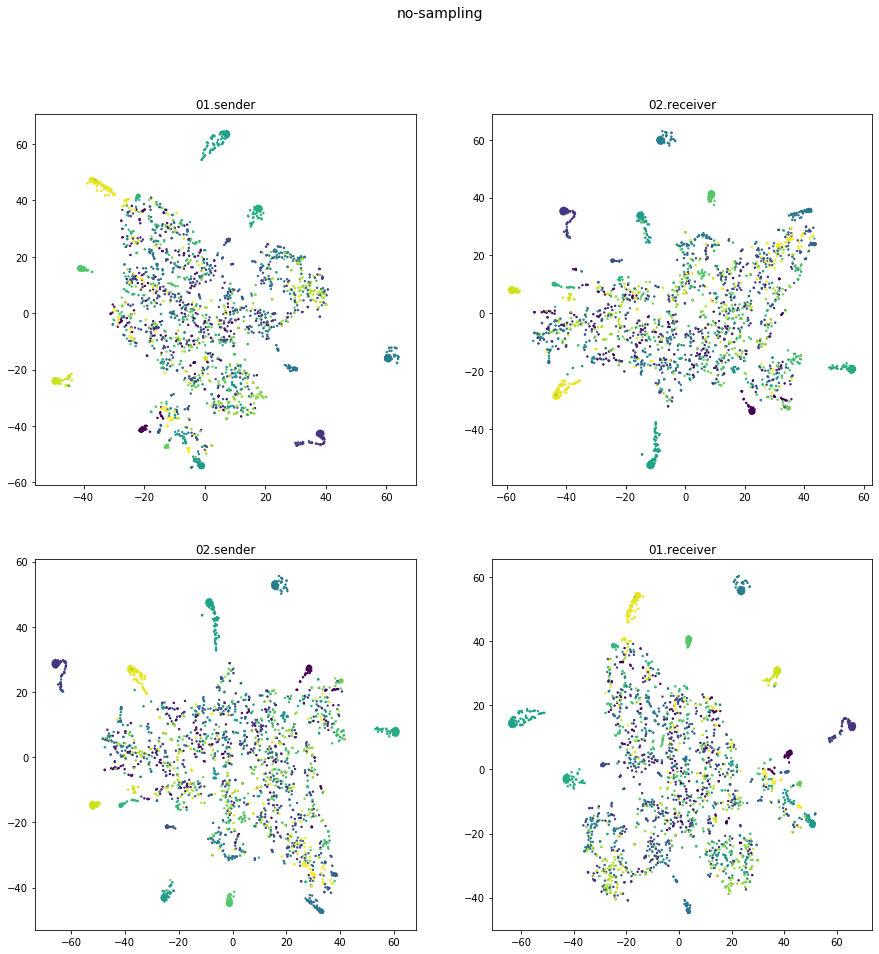

In [75]:
reduce_and_plot(*embs[0], categories, model_args)

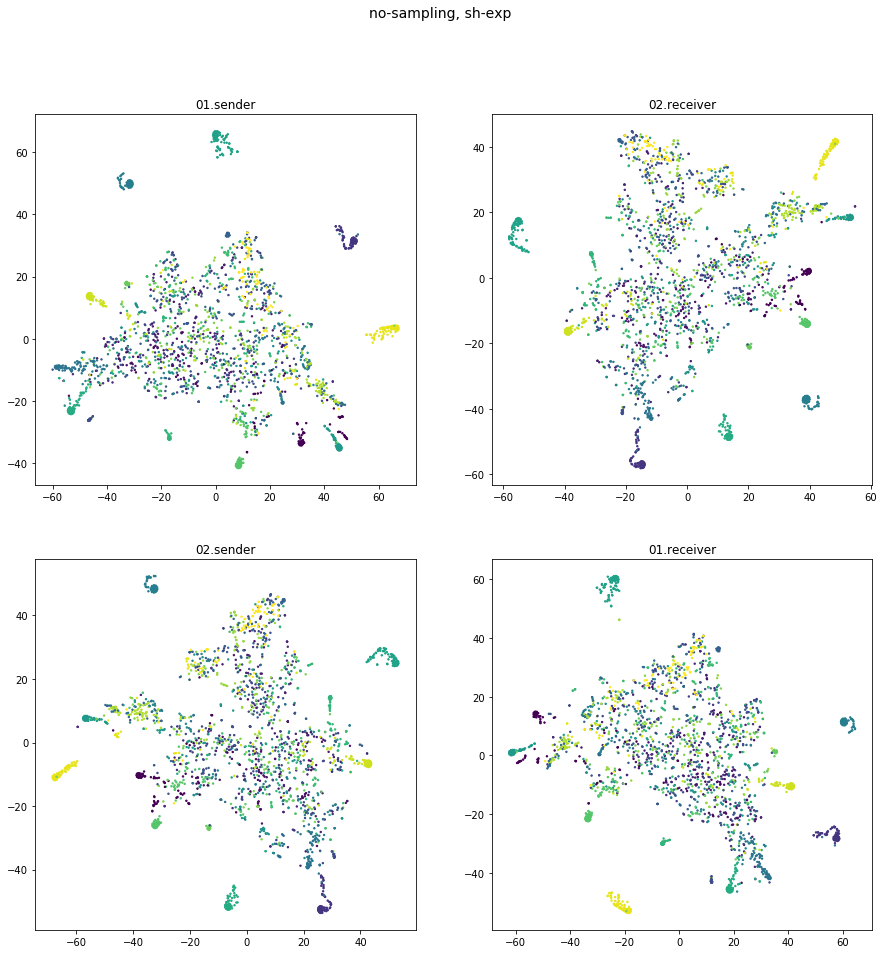

In [51]:
reduce_and_plot(*embs[1])

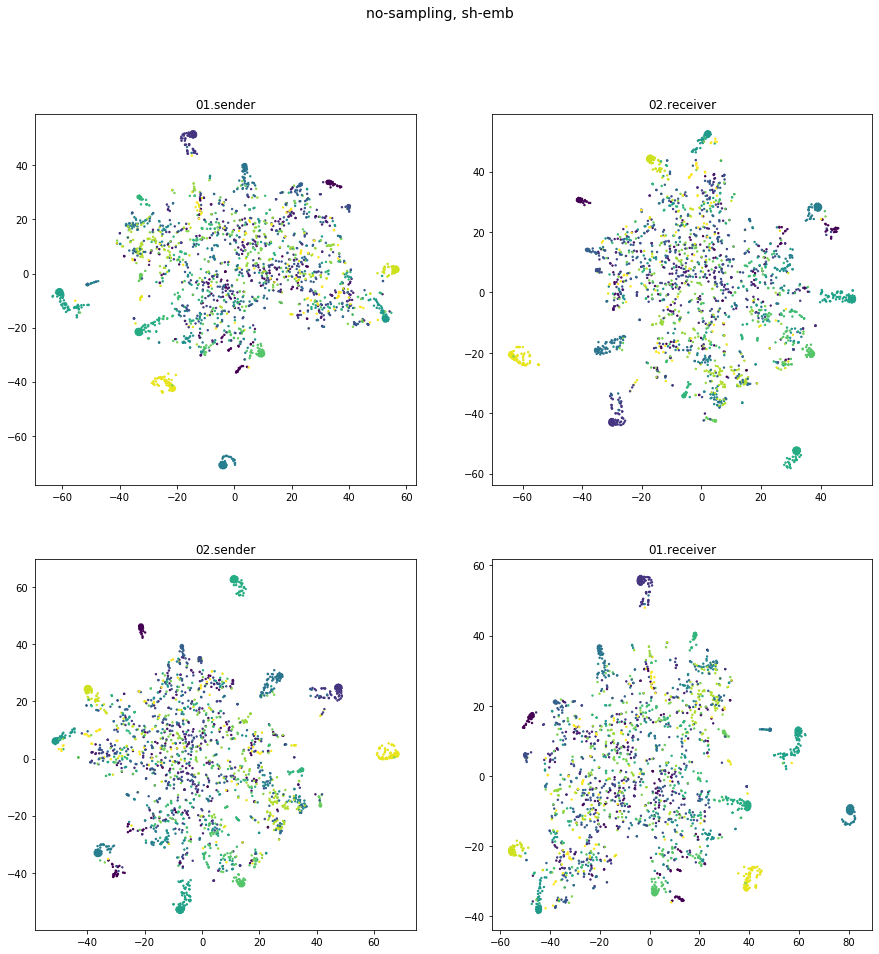

In [52]:
reduce_and_plot(*embs[2])

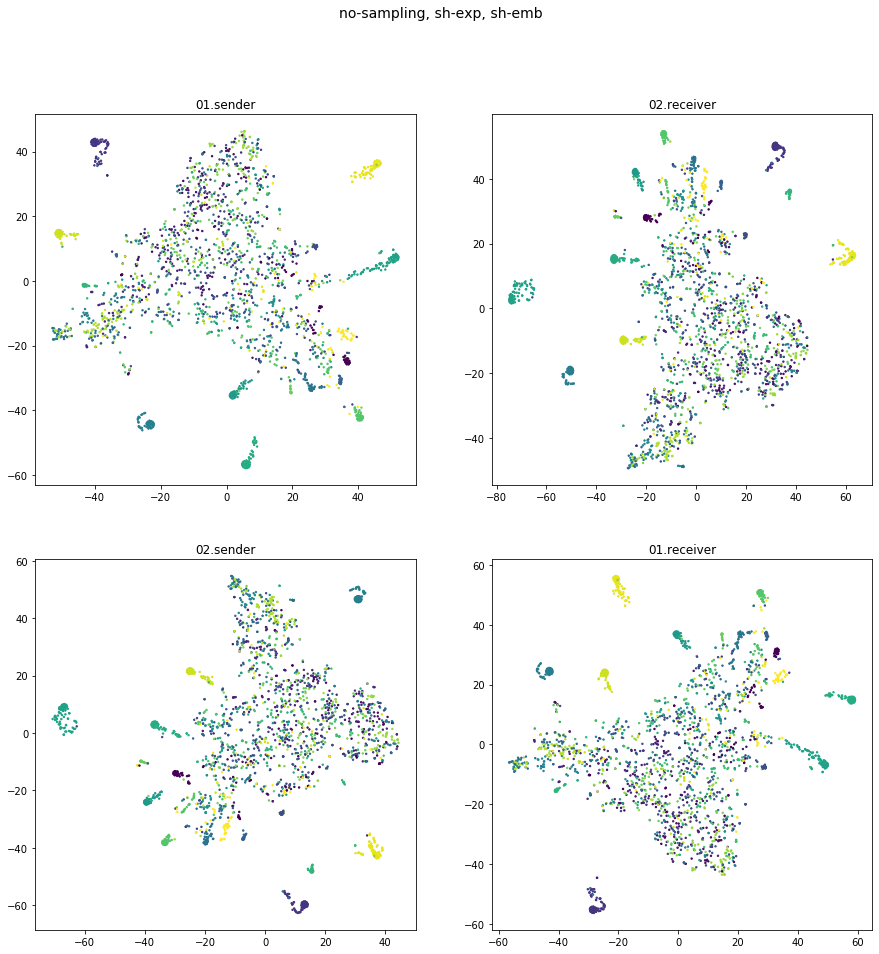

In [53]:
reduce_and_plot(*embs[3])

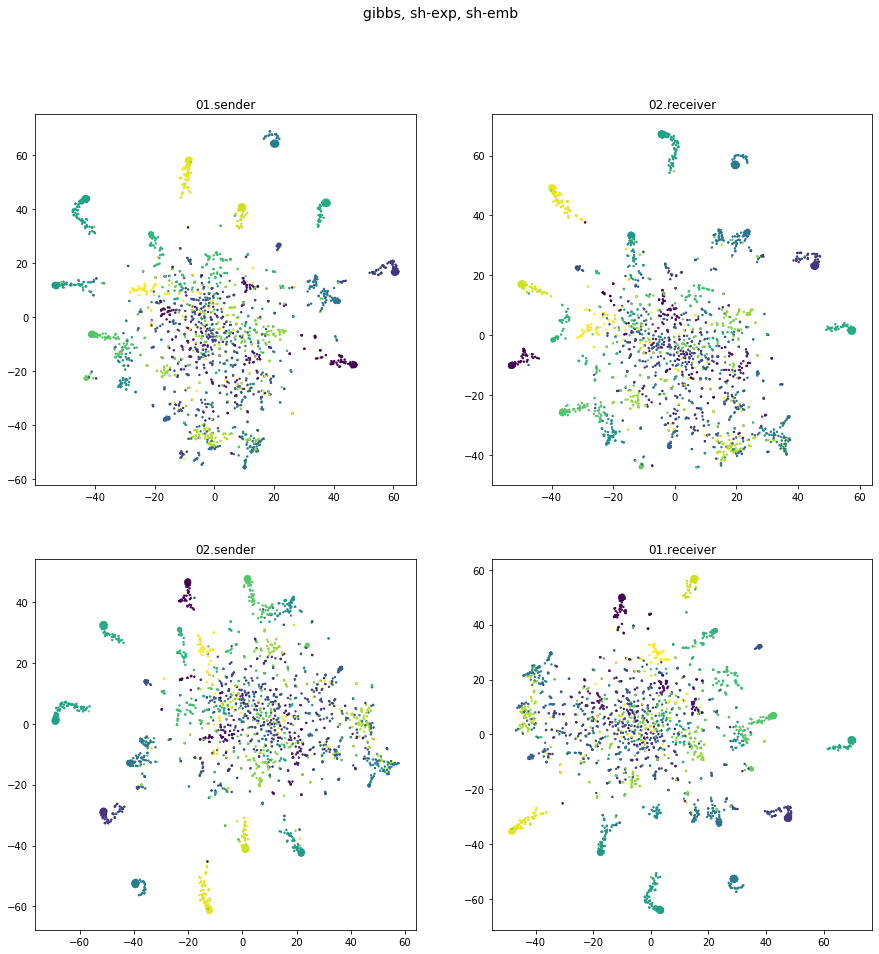

In [54]:
reduce_and_plot(*embs[4])